# New Clue
In this notebook, we'll test the new, simplified CLUE implementation. We're not using Bayesian Neural Networks here, so the uncertainty is just the entropy of the classifier.

## Setup


Import libraries

In [23]:
import importlib
import models.regene_models as regene_models
importlib.reload(regene_models)
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import clue.new_CLUE as new_CLUE
importlib.reload(new_CLUE)
import models.BLL
import models.mnist_classifier_BLL


Set the device

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


Load the Datasets

In [9]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

Set the latent dimension

In [4]:
latent_dim = 256

Create a models directory if it doesn't exist

In [5]:
# Create models directory if it doesn't exist
os.makedirs('../model_saves', exist_ok=True)
model_saves_dir = '../model_saves'

## Prepare the Backbone and Decoder
We'll be testing the CLUE implementation on the BLL model. We first need load (or train) the decoder.

### Load the models

We load the backbone classifier

In [17]:
importlib.reload(mnist_classifier_BLL)  # Reload the module
from models.mnist_classifier_BLL import MNISTClassifierBLL  # Import the class

backbone = MNISTClassifierBLL(device=device)
print(f"Backbone will run on: {device}")

Backbone will run on: mps


Load weights

In [18]:
backbone.load_weights(model_saves_dir + '/mnist_backbone_models/backbone_best_12_epochs.pt')

 [load_weights] Loaded backbone weights from ../model_saves/mnist_backbone_models/backbone_best_12_epochs.pt


/Users/conor/Documents/College terms/College/Thesis/Thesis_Code_Minimised/MyImplementation/models/mnist_classifier_BLL.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s

Next, load the decoder

In [19]:
decoder = regene_models.Decoder(latent_dim=latent_dim, device=device)

In [20]:
decoder.train_decoder(trainloader, backbone, num_epochs=12, lr=0.001)
torch.save(decoder.state_dict(), os.path.join(model_saves_dir, 'decoder_BLL.pth'))

Decoder Epoch [1/12], Loss: 0.0161
Decoder Epoch [2/12], Loss: 0.0106
Decoder Epoch [3/12], Loss: 0.0121
Decoder Epoch [4/12], Loss: 0.0113
Decoder Epoch [5/12], Loss: 0.0090
Decoder Epoch [6/12], Loss: 0.0082
Decoder Epoch [7/12], Loss: 0.0086
Decoder Epoch [8/12], Loss: 0.0079
Decoder Epoch [9/12], Loss: 0.0090
Decoder Epoch [10/12], Loss: 0.0088
Decoder Epoch [11/12], Loss: 0.0092
Decoder Epoch [12/12], Loss: 0.0092


## Load the BLL classifier

In [81]:
from models.BLL import BayesianLastLayerCat
importlib.reload(models.BLL)

bll = BayesianLastLayerCat(
    backbone=backbone,
    input_dim=256,  # Matches backbone's encoder output
    output_dim=10,  # MNIST classes
    N_train=len(trainset),
    lr=0.001,
    base_C=1.0,
    gauss_sig=0.01,
    device=device
)

In [82]:
bll.load_checkpoint(model_saves_dir + '/mnist_bll_models/BLL_checkpoint_100_epochs.pth')

 [load_checkpoint] Loaded checkpoint from ../model_saves/mnist_bll_models/BLL_checkpoint_100_epochs.pth


/Users/conor/Documents/College terms/College/Thesis/Thesis_Code_Minimised/MyImplementation/models/BLL.py:313: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torc

## Get uncertain images

Get the most uncertain images, we need a non-shuffled loader for this.

In [61]:
# Create a non-shuffled loader for uncertainty calculation
eval_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Get uncertainty scores for all test set data points
uncertainties = []
indices = []

bll.eval()
with torch.no_grad():
    for i, (images, _) in enumerate(eval_loader):
        images = images.to(device)
        # Get predictions and uncertainties using BLL model
        _, uncertainty_dict = bll.predict_with_uncertainty(images)
        
        # Store total uncertainties and indices
        uncertainties.extend(uncertainty_dict['total_entropy'].cpu().numpy())
        indices.extend(range(i*eval_loader.batch_size, min((i+1)*eval_loader.batch_size, len(testset))))

# Convert to numpy arrays
uncertainties = np.array(uncertainties)
indices = np.array(indices)

# Sort by uncertainty (descending order)
sorted_idx = np.argsort(-uncertainties)
sorted_uncertainties = uncertainties[sorted_idx]
sorted_data_indices = indices[sorted_idx]

We then plot the plot the most uncertain predictions on the test set.

In [62]:
import matplotlib.pyplot as plt
import torch

def plot_most_uncertain(testset, sorted_data_indices, sorted_uncertainties, n_plot=5):
    """
    Plots the top-n most uncertain predictions from the training set.

    Args:
        testset (torch.utils.data.Dataset): Dataset that returns (image, label) samples.
        sorted_data_indices (np.ndarray): Array of indices sorted in descending order by uncertainty.
        sorted_uncertainties (np.ndarray): Array of uncertainty (entropy) values, sorted to match sorted_data_indices.
        n_plot (int): Number of images to plot.
    """
    # Calculate number of rows needed
    images_per_row = 10
    n_rows = (n_plot - 1) // images_per_row + 1
    
    plt.figure(figsize=(15, 3 * n_rows))
    for i in range(n_plot):
        data_idx = sorted_data_indices[i]
        image, _ = testset[data_idx]
        
        # If image is a torch.Tensor, convert it to a NumPy array.
        if torch.is_tensor(image):
            image = image.cpu().detach().numpy()
            # If the image has one channel [1, H, W], squeeze out the channel dimension.
            if image.ndim == 3 and image.shape[0] == 1:
                image = image.squeeze(0)
        
        row = i // images_per_row
        col = i % images_per_row
        plt.subplot(n_rows, images_per_row, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Entropy: {sorted_uncertainties[i]:.2f}")
        plt.axis("off")
    
    plt.suptitle("Most Uncertain Predictions")
    plt.show()

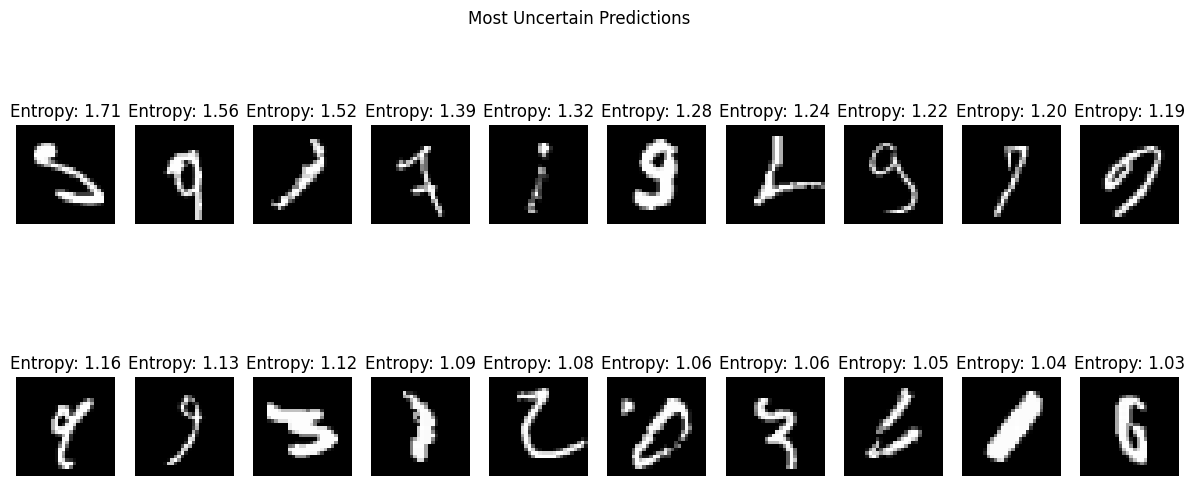

In [75]:
# Plot the most uncertain predictions
plot_most_uncertain(testset, sorted_data_indices, sorted_uncertainties, n_plot=20)

In [86]:
import torch.nn.functional as F
import clue.new_CLUE as new_CLUE
importlib.reload(new_CLUE)

# Get the most uncertain image and its latent representation
most_uncertain_idx = sorted_data_indices[6]
uncertain_image, _ = testset[most_uncertain_idx]
uncertain_image = uncertain_image.to(device).unsqueeze(0)  # Add batch dimension

# Get its latent representation
bll.eval()
with torch.no_grad():
    z0 = bll.extract_features(uncertain_image)

# Initialize CLUE
clue = new_CLUE.NewCLUE(
    classifier=bll,
    z0=z0,
    uncertainty_weight=1.0,
    distance_weight=0,  # Set to 0 to focus on uncertainty
    lr=0.1,
    device=device,
    bayesian=True
)

# Debug test cell
with torch.no_grad():
    # Method 1: Using CLUE's predict_uncertainty_bayesian
    probs_clue = bll.sample_predict_z(z0)
    print("\nCLUE Method:")
    print(f"Probs shape: {probs_clue.shape}")
    print(f"First ensemble probabilities:\n{probs_clue[0]}")
    print(f"Mean probabilities:\n{probs_clue.mean(dim=0)}")
    
    # Calculate entropies manually for CLUE
    posterior_preds_clue = probs_clue.mean(dim=0)
    total_entropy_clue = -(posterior_preds_clue * torch.log(posterior_preds_clue + 1e-10)).sum(dim=1)
    sample_preds_entropy_clue = -(probs_clue * torch.log(probs_clue + 1e-10)).sum(dim=2)
    aleatoric_entropy_clue = sample_preds_entropy_clue.mean(dim=0)
    epistemic_entropy_clue = total_entropy_clue - aleatoric_entropy_clue
    
    print(f"\nManually calculated CLUE entropies:")
    print(f"Total Entropy: {total_entropy_clue.item():.4f}")
    print(f"Aleatoric Entropy: {aleatoric_entropy_clue.item():.4f}")
    print(f"Epistemic Entropy: {epistemic_entropy_clue.item():.4f}")
    
    # Method 2: Using predict_with_uncertainty
    features = bll.extract_features(uncertain_image)
    print("\nPredict_with_uncertainty method:")
    all_probs = []
    for last_layer in bll.ensemble_last_layers:
        logits = last_layer(features)
        probs = F.softmax(logits, dim=1)
        all_probs.append(probs)
    
    prob_stack = torch.stack(all_probs, dim=0)
    print(f"Prob stack shape: {prob_stack.shape}")
    print(f"First ensemble probabilities:\n{prob_stack[0]}")
    print(f"Mean probabilities:\n{prob_stack.mean(dim=0)}")
    
    # Print sums to verify normalization
    print("\nProbability sums:")
    print(f"CLUE probs sum: {probs_clue[0].sum().item():.4f}")
    print(f"Regular probs sum: {prob_stack[0].sum().item():.4f}")



CLUE Method:
Probs shape: torch.Size([20, 1, 10])
First ensemble probabilities:
tensor([[4.6126e-06, 1.9640e-01, 7.9538e-02, 3.3834e-09, 2.9720e-01, 4.7067e-07,
         4.2673e-01, 2.1871e-06, 1.1819e-04, 4.0386e-11]], device='mps:0')
Mean probabilities:
tensor([[2.0699e-06, 9.9568e-02, 1.3949e-01, 2.3294e-09, 3.5538e-01, 7.7840e-07,
         4.0538e-01, 2.8067e-06, 1.8381e-04, 6.9529e-11]], device='mps:0')

Manually calculated CLUE entropies:
Total Entropy: 1.2398
Aleatoric Entropy: 1.2018
Epistemic Entropy: 0.0380

Predict_with_uncertainty method:
Prob stack shape: torch.Size([20, 1, 10])
First ensemble probabilities:
tensor([[4.6126e-06, 1.9640e-01, 7.9538e-02, 3.3834e-09, 2.9720e-01, 4.7067e-07,
         4.2673e-01, 2.1871e-06, 1.1819e-04, 4.0386e-11]], device='mps:0')
Mean probabilities:
tensor([[2.0699e-06, 9.9568e-02, 1.3949e-01, 2.3294e-09, 3.5538e-01, 7.7840e-07,
         4.0538e-01, 2.8067e-06, 1.8381e-04, 6.9529e-11]], device='mps:0')

Probability sums:
CLUE probs sum: 1.0

### Test new CLUE implementation

Now we test the "new" CLUE implementation, which accepts only a classifier head, directly optimising the latent code. There is no need for a decoder at each step (and therefore inside the CLUE method). 
Once the latent code is optimised, we pass it through the decoder to get a reconstruction from this notebook.

Step 00: Loss: 1.2398, Total Entropy: 1.2398, Epistemic Entropy: 0.0380, Aleatoric Entropy: 1.2018, Distance: 0.0000
Step 01: Loss: 0.7503, Total Entropy: 0.7502, Epistemic Entropy: 0.0210, Aleatoric Entropy: 0.7292, Distance: 1.6000
Step 02: Loss: 0.2473, Total Entropy: 0.2470, Epistemic Entropy: 0.0054, Aleatoric Entropy: 0.2416, Distance: 2.6992
Step 03: Loss: 0.0389, Total Entropy: 0.0385, Epistemic Entropy: 0.0006, Aleatoric Entropy: 0.0380, Distance: 3.7869
Step 04: Loss: 0.0067, Total Entropy: 0.0062, Epistemic Entropy: 0.0001, Aleatoric Entropy: 0.0061, Distance: 4.7945
Step 05: Loss: 0.0018, Total Entropy: 0.0012, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.0012, Distance: 5.6838
Step 06: Loss: 0.0009, Total Entropy: 0.0003, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.0003, Distance: 6.4650
Step 07: Loss: 0.0008, Total Entropy: 0.0001, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.0001, Distance: 7.1541
Step 08: Loss: 0.0008, Total Entropy: 0.0000, Epistemic Entropy:

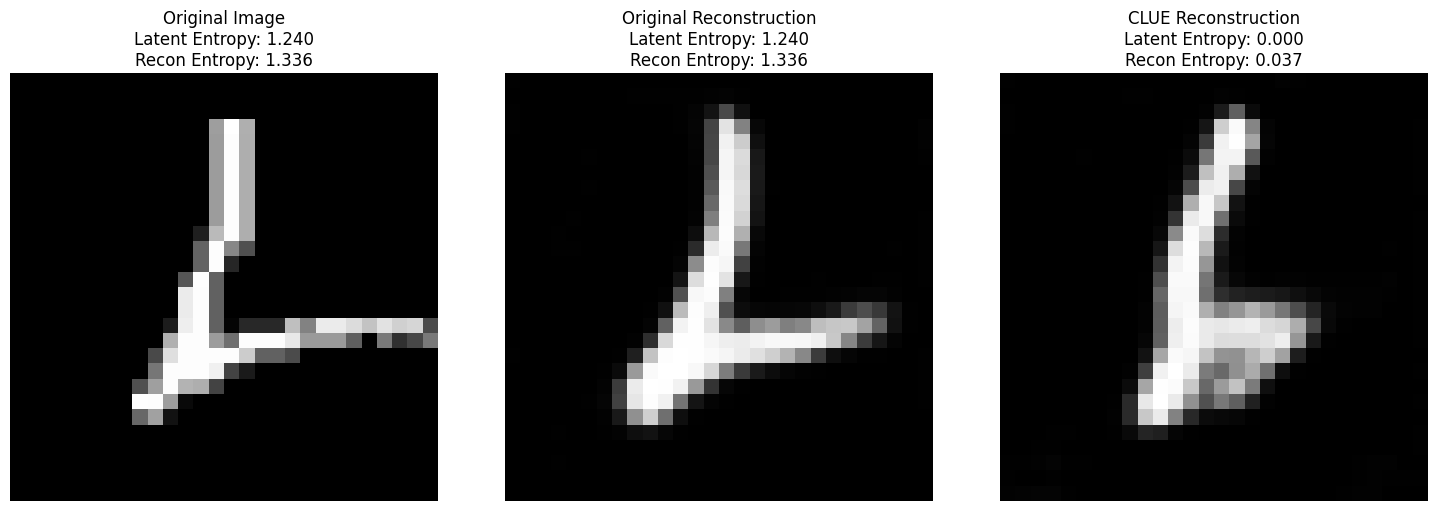

In [90]:
# Get the most uncertain image and its latent representation
most_uncertain_idx = sorted_data_indices[6]
uncertain_image, _ = testset[most_uncertain_idx]
uncertain_image = uncertain_image.to(device).unsqueeze(0)  # Add batch dimension

# Get its latent representation
bll.eval()
with torch.no_grad():
    z0 = bll.extract_features(uncertain_image)

# Initialize CLUE
clue = new_CLUE.NewCLUE(
    classifier=bll,
    z0=z0,
    uncertainty_weight=1.0,
    distance_weight=0.0001,
    lr=0.1,
    device=device,
    bayesian=True
)

# Optimize to find explanation
z_explained = clue.optimize(steps=200)

# Generate reconstructions using decoder
with torch.no_grad():
    # Original reconstruction
    original_recon = decoder(z0)
    # CLUE reconstruction  
    clue_recon = decoder(z_explained)
    
    # Get predictions and uncertainties from latent codes
    original_probs_latent = bll.sample_predict_z(z0)  # [n_ensemble, batch, classes]
    explained_probs_latent = bll.sample_predict_z(z_explained)
    
    # Get predictions from full classifier workflow on reconstructions
    original_probs_recon = bll.sample_predict(original_recon)
    explained_probs_recon = bll.sample_predict(clue_recon)
    
    # Calculate mean probabilities and entropies for latent predictions
    original_mean_probs_latent = original_probs_latent.mean(dim=0)  # [batch, classes]
    explained_mean_probs_latent = explained_probs_latent.mean(dim=0)
    
    original_entropy_latent = -(original_mean_probs_latent * torch.log(original_mean_probs_latent + 1e-10)).sum(dim=1)
    explained_entropy_latent = -(explained_mean_probs_latent * torch.log(explained_mean_probs_latent + 1e-10)).sum(dim=1)
    
    # Calculate mean probabilities and entropies for reconstruction predictions
    original_mean_probs_recon = original_probs_recon.mean(dim=0)
    explained_mean_probs_recon = explained_probs_recon.mean(dim=0)
    
    original_entropy_recon = -(original_mean_probs_recon * torch.log(original_mean_probs_recon + 1e-10)).sum(dim=1)
    explained_entropy_recon = -(explained_mean_probs_recon * torch.log(explained_mean_probs_recon + 1e-10)).sum(dim=1)

# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(uncertain_image[0,0].cpu(), cmap='gray')
plt.title(f'Original Image\nLatent Entropy: {original_entropy_latent[0]:.3f}\nRecon Entropy: {original_entropy_recon[0]:.3f}')
plt.axis('off')

plt.subplot(132)
plt.imshow(original_recon[0,0].cpu().detach(), cmap='gray')
plt.title(f'Original Reconstruction\nLatent Entropy: {original_entropy_latent[0]:.3f}\nRecon Entropy: {original_entropy_recon[0]:.3f}')
plt.axis('off')

plt.subplot(133)
plt.imshow(clue_recon[0,0].cpu().detach(), cmap='gray')
plt.title(f'CLUE Reconstruction\nLatent Entropy: {explained_entropy_latent[0]:.3f}\nRecon Entropy: {explained_entropy_recon[0]:.3f}')
plt.axis('off')

plt.tight_layout()
plt.show()


So we see that, while the entropy of the optimised latent code is near zero, the reconstuction looks identical to the original recosntruction of the test image. Indeed, passing the _reconstructed_ image through the entire classification pipeline (encoder -> classification head) results in almost the same entropy as before. It seems that the latent point is adversarial, and gets project back to the original in-distribution image.

Below, we plot the t-SNE of the latent space of the test set. We can see that the optimised latent code is close to the original latent code, but not identical.


Distance between original and explained points in t-SNE space: 0.117


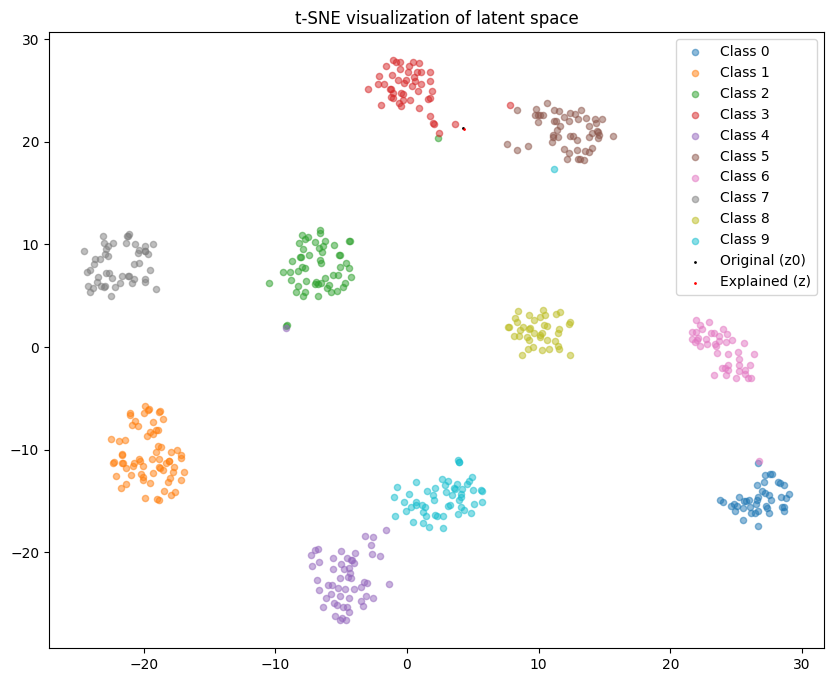

In [25]:
# Get latent codes for 500 training images to create TSNE visualization
latent_codes = []
labels_list = []
with torch.no_grad():
    for i, (images, labels) in enumerate(testloader):
        if i >= 500/images.shape[0]:  # Stop after ~500 images
            break
        images = images.to(device)
        z, _ = classifier(images)
        latent_codes.append(z.cpu())
        labels_list.append(labels)
latent_codes = torch.cat(latent_codes, dim=0)
labels = torch.cat(labels_list, dim=0)

# Add z0 and z_explained to the latent codes
all_latents = torch.cat([latent_codes, z0.cpu(), z_explained.cpu()], dim=0)

# Perform t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
latents_2d = tsne.fit_transform(all_latents.numpy())

# Plot t-SNE
plt.figure(figsize=(10, 8))

# Create scatter plot for each class
testing_latents_2d = latents_2d[:-2]
for i in range(10):
    mask = labels == i
    plt.scatter(testing_latents_2d[mask, 0], testing_latents_2d[mask, 1], 
               alpha=0.5, label=f'Class {i}', s=20)  # Reduced point size to 20

# Plot original and explained points
plt.scatter(latents_2d[-2, 0], latents_2d[-2, 1], c='black', s=1, label='Original (z0)')
plt.scatter(latents_2d[-1, 0], latents_2d[-1, 1], c='red', s=1, label='Explained (z)')
plt.plot([latents_2d[-2, 0], latents_2d[-1, 0]], 
         [latents_2d[-2, 1], latents_2d[-1, 1]], 
         'k--', alpha=0.5)

# Calculate and print distance between original and explained points in t-SNE space
tsne_distance = np.sqrt(np.sum((latents_2d[-2] - latents_2d[-1])**2))
print(f"\nDistance between original and explained points in t-SNE space: {tsne_distance:.3f}")

plt.title('t-SNE visualization of latent space')
plt.legend()
plt.show()
